In [1]:
import my_utils
import torch

In [2]:
#定义模型

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
 
      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
 
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
 
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
 
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
 
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
 
    return model

In [3]:
#数据增强

import utils
import transforms as T



def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [4]:
from engine import train_one_epoch, evaluate
# import math
# import sys
# import time

# import torch
# import torchvision.models.detection.mask_rcnn
# import utils
# from coco_eval import CocoEvaluator
# from coco_utils import get_coco_api_from_dataset
# def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
#     model.train()
#     metric_logger = utils.MetricLogger(delimiter="  ")
#     metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
#     header = f"Epoch: [{epoch}]"

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000
#         warmup_iters = min(1000, len(data_loader) - 1)

#         lr_scheduler = torch.optim.lr_scheduler.LinearLR(
#             optimizer, start_factor=warmup_factor, total_iters=warmup_iters
#         )

#     for images, targets in metric_logger.log_every(data_loader, print_freq, header):
# #         print(images[0].shape)  torch.Size([3, 1672, 968])
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         with torch.cuda.amp.autocast(enabled=scaler is not None):
#             loss_dict = model(images, targets)
#             losses = sum(loss for loss in loss_dict.values())

#         # reduce losses over all GPUs for logging purposes
#         loss_dict_reduced = utils.reduce_dict(loss_dict)
#         losses_reduced = sum(loss for loss in loss_dict_reduced.values())

#         loss_value = losses_reduced.item()

#         if not math.isfinite(loss_value):
#             print(f"Loss is {loss_value}, stopping training")
#             print(loss_dict_reduced)
#             sys.exit(1)

#         optimizer.zero_grad()
#         if scaler is not None:
#             scaler.scale(losses).backward()
#             scaler.step(optimizer)
#             scaler.update()
#         else:
#             losses.backward()
#             optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step()

#         metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
#         metric_logger.update(lr=optimizer.param_groups[0]["lr"])

#     return metric_logger


In [5]:
#359 bbox有问题

# use the PennFudan dataset and defined transformations

dataset =   my_utils.google_dataset('mydata/object_segment/val')
dataset_test = my_utils.google_dataset('mydata/object_segment/val')
# dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
# dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=True))
# split the dataset in train and test set
torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist() #打乱顺序
indices = list(range(0,len(dataset)))
# dataset = torch.utils.data.Subset(dataset, indices[:-10])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-10:])
dataset = torch.utils.data.Subset(dataset, indices[:-10])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-10:])
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)
 
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)
 
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
 
# the dataset has two classes only - background and person
num_classes = 17
 
# get the model using the helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)
 
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
 
# the learning rate scheduler decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
 
# training

num_epochs = 1
for epoch in range(num_epochs):
    print(epoch)
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
 
    # update the learning rate
    lr_scheduler.step()
 
    # evaluate on the test dataset
#     evaluate(model, data_loader_test, device=device)
print('done')

C:\Users\10369\.conda\envs\rcnn\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\10369\.conda\envs\rcnn\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0
Epoch: [0]  [ 0/35]  eta: 0:04:15  lr: 0.000152  loss: 5.7059 (5.7059)  loss_classifier: 2.5808 (2.5808)  loss_box_reg: 0.8506 (0.8506)  loss_mask: 0.9056 (0.9056)  loss_objectness: 1.2645 (1.2645)  loss_rpn_box_reg: 0.1044 (0.1044)  time: 7.2996  data: 4.4741  max mem: 1227
Epoch: [0]  [ 1/35]  eta: 0:02:07  lr: 0.000299  loss: 5.3453 (5.5256)  loss_classifier: 2.5600 (2.5704)  loss_box_reg: 0.8506 (0.8713)  loss_mask: 0.9056 (0.9552)  loss_objectness: 0.8172 (1.0409)  loss_rpn_box_reg: 0.0715 (0.0879)  time: 3.7613  data: 2.2418  max mem: 1476
Epoch: [0]  [ 2/35]  eta: 0:01:25  lr: 0.000446  loss: 5.3453 (5.3430)  loss_classifier: 2.5600 (2.5651)  loss_box_reg: 0.8506 (0.8371)  loss_mask: 0.9056 (0.9359)  loss_objectness: 0.8172 (0.9042)  loss_rpn_box_reg: 0.1044 (0.1006)  time: 2.5813  data: 1.4979  max mem: 1484
Epoch: [0]  [ 3/35]  eta: 0:01:03  lr: 0.000593  loss: 4.9777 (5.1188)  loss_classifier: 2.5546 (2.5340)  loss_box_reg: 0.8506 (0.8428)  loss_mask: 0.8975 (0.8903)  loss_

Epoch: [0]  [30/35]  eta: 0:00:06  lr: 0.004559  loss: 2.4402 (3.0206)  loss_classifier: 0.8379 (1.1545)  loss_box_reg: 0.7773 (0.6690)  loss_mask: 0.6087 (0.8161)  loss_objectness: 0.1189 (0.2761)  loss_rpn_box_reg: 0.1048 (0.1049)  time: 1.0872  data: 0.8015  max mem: 1950
Epoch: [0]  [31/35]  eta: 0:00:04  lr: 0.004706  loss: 2.4402 (3.0154)  loss_classifier: 0.8200 (1.1429)  loss_box_reg: 0.7575 (0.6696)  loss_mask: 0.6011 (0.8061)  loss_objectness: 0.1285 (0.2859)  loss_rpn_box_reg: 0.1048 (0.1109)  time: 1.1505  data: 0.8635  max mem: 1950
Epoch: [0]  [32/35]  eta: 0:00:04  lr: 0.004853  loss: 2.4402 (2.9935)  loss_classifier: 0.8379 (1.1373)  loss_box_reg: 0.7575 (0.6656)  loss_mask: 0.5978 (0.7947)  loss_objectness: 0.1285 (0.2809)  loss_rpn_box_reg: 0.1141 (0.1148)  time: 1.6703  data: 1.3717  max mem: 1993
Epoch: [0]  [33/35]  eta: 0:00:02  lr: 0.005000  loss: 2.4402 (2.9771)  loss_classifier: 0.8379 (1.1279)  loss_box_reg: 0.7665 (0.6686)  loss_mask: 0.5895 (0.7853)  loss_ob

In [6]:
# 模型保存
torch.save(model, 'model/model_object.pkl')

In [7]:
# 模型加载
model = torch.load('model/model_object.pkl')

In [1]:
#继续训练
import my_utils
import torch
from engine import train_one_epoch, evaluate
import utils
import transforms as T
# get the model using the helper function
model = torch.load('model/model_object.pkl')
# move model to the right device
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
model.to(device)
dataset =   my_utils.google_dataset('mydata/object_segment/val')
dataset_test = my_utils.google_dataset('mydata/object_segment/val')
torch.manual_seed(1)
indices = list(range(0,len(dataset)))
dataset = torch.utils.data.Subset(dataset, indices[:-5])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-5:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)
 
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)
 


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
 
# the learning rate scheduler decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
 
# training

num_epochs = 5
for epoch in range(num_epochs):
    print(epoch)
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
 
    # update the learning rate
    lr_scheduler.step()
 
    # evaluate on the test dataset
#     evaluate(model, data_loader_test, device=device)
print('done')

0
Epoch: [0]  [ 0/40]  eta: 0:04:44  lr: 0.000133  loss: 2.1796 (2.1796)  loss_classifier: 0.5359 (0.5359)  loss_box_reg: 0.8469 (0.8469)  loss_mask: 0.4290 (0.4290)  loss_objectness: 0.1437 (0.1437)  loss_rpn_box_reg: 0.2242 (0.2242)  time: 7.1083  data: 4.3293  max mem: 1227
Epoch: [0]  [ 1/40]  eta: 0:02:23  lr: 0.000261  loss: 1.9372 (2.0584)  loss_classifier: 0.5222 (0.5290)  loss_box_reg: 0.7729 (0.8099)  loss_mask: 0.4290 (0.4332)  loss_objectness: 0.0517 (0.0977)  loss_rpn_box_reg: 0.1531 (0.1886)  time: 3.6726  data: 2.1647  max mem: 1476
Epoch: [0]  [ 2/40]  eta: 0:01:35  lr: 0.000389  loss: 1.9372 (1.9797)  loss_classifier: 0.5222 (0.5037)  loss_box_reg: 0.7729 (0.7851)  loss_mask: 0.4290 (0.4240)  loss_objectness: 0.0675 (0.0876)  loss_rpn_box_reg: 0.1608 (0.1794)  time: 2.5206  data: 1.4455  max mem: 1484
Epoch: [0]  [ 3/40]  eta: 0:01:12  lr: 0.000517  loss: 1.9156 (1.9637)  loss_classifier: 0.4749 (0.4965)  loss_box_reg: 0.7563 (0.7779)  loss_mask: 0.4056 (0.4161)  loss_

Epoch: [0]  [30/40]  eta: 0:00:12  lr: 0.003975  loss: 1.7009 (1.6929)  loss_classifier: 0.4918 (0.5323)  loss_box_reg: 0.6411 (0.6064)  loss_mask: 0.3732 (0.3699)  loss_objectness: 0.0431 (0.0782)  loss_rpn_box_reg: 0.1015 (0.1060)  time: 1.1419  data: 0.8466  max mem: 1950
Epoch: [0]  [31/40]  eta: 0:00:11  lr: 0.004103  loss: 1.7401 (1.6993)  loss_classifier: 0.4983 (0.5341)  loss_box_reg: 0.6411 (0.6099)  loss_mask: 0.3732 (0.3695)  loss_objectness: 0.0437 (0.0775)  loss_rpn_box_reg: 0.1015 (0.1085)  time: 1.1756  data: 0.8797  max mem: 1950
Epoch: [0]  [32/40]  eta: 0:00:12  lr: 0.004232  loss: 1.8248 (1.7108)  loss_classifier: 0.5511 (0.5408)  loss_box_reg: 0.6411 (0.6095)  loss_mask: 0.3732 (0.3694)  loss_objectness: 0.0537 (0.0776)  loss_rpn_box_reg: 0.1091 (0.1136)  time: 1.7056  data: 1.3889  max mem: 1997
Epoch: [0]  [33/40]  eta: 0:00:10  lr: 0.004360  loss: 1.8248 (1.6924)  loss_classifier: 0.5511 (0.5341)  loss_box_reg: 0.6411 (0.6058)  loss_mask: 0.3732 (0.3637)  loss_ob

Epoch: [1]  [20/40]  eta: 0:00:22  lr: 0.005000  loss: 1.6289 (1.6377)  loss_classifier: 0.4669 (0.5241)  loss_box_reg: 0.5499 (0.5693)  loss_mask: 0.3196 (0.3253)  loss_objectness: 0.0545 (0.0803)  loss_rpn_box_reg: 0.1091 (0.1387)  time: 0.9461  data: 0.7134  max mem: 1997
Epoch: [1]  [21/40]  eta: 0:00:23  lr: 0.005000  loss: 1.6179 (1.6278)  loss_classifier: 0.4615 (0.5161)  loss_box_reg: 0.5490 (0.5683)  loss_mask: 0.3147 (0.3240)  loss_objectness: 0.0458 (0.0775)  loss_rpn_box_reg: 0.1091 (0.1418)  time: 1.0963  data: 0.8542  max mem: 1997
Epoch: [1]  [22/40]  eta: 0:00:22  lr: 0.005000  loss: 1.6179 (1.6485)  loss_classifier: 0.4615 (0.5218)  loss_box_reg: 0.5490 (0.5752)  loss_mask: 0.3147 (0.3283)  loss_objectness: 0.0458 (0.0809)  loss_rpn_box_reg: 0.1091 (0.1423)  time: 1.1254  data: 0.8832  max mem: 1997
Epoch: [1]  [23/40]  eta: 0:00:21  lr: 0.005000  loss: 1.6179 (1.6489)  loss_classifier: 0.4615 (0.5193)  loss_box_reg: 0.5490 (0.5775)  loss_mask: 0.3147 (0.3320)  loss_ob

Epoch: [2]  [10/40]  eta: 0:00:40  lr: 0.005000  loss: 1.4756 (1.4145)  loss_classifier: 0.4518 (0.4790)  loss_box_reg: 0.5368 (0.5165)  loss_mask: 0.3196 (0.2823)  loss_objectness: 0.0512 (0.0543)  loss_rpn_box_reg: 0.0904 (0.0824)  time: 1.3626  data: 1.1079  max mem: 1997
Epoch: [2]  [11/40]  eta: 0:00:37  lr: 0.005000  loss: 1.4756 (1.4292)  loss_classifier: 0.4092 (0.4732)  loss_box_reg: 0.5368 (0.5213)  loss_mask: 0.3196 (0.2893)  loss_objectness: 0.0443 (0.0515)  loss_rpn_box_reg: 0.0904 (0.0940)  time: 1.2956  data: 1.0443  max mem: 1997
Epoch: [2]  [12/40]  eta: 0:00:33  lr: 0.005000  loss: 1.4756 (1.4121)  loss_classifier: 0.4092 (0.4657)  loss_box_reg: 0.5525 (0.5271)  loss_mask: 0.3196 (0.2823)  loss_objectness: 0.0443 (0.0489)  loss_rpn_box_reg: 0.0904 (0.0882)  time: 1.2141  data: 0.9651  max mem: 1997
Epoch: [2]  [13/40]  eta: 0:00:30  lr: 0.005000  loss: 1.3649 (1.3935)  loss_classifier: 0.4060 (0.4611)  loss_box_reg: 0.5368 (0.5272)  loss_mask: 0.2929 (0.2719)  loss_ob

Epoch: [2] Total time: 0:00:57 (1.4312 s / it)
3
Epoch: [3]  [ 0/40]  eta: 0:03:15  lr: 0.000500  loss: 1.4324 (1.4324)  loss_classifier: 0.3739 (0.3739)  loss_box_reg: 0.5951 (0.5951)  loss_mask: 0.2894 (0.2894)  loss_objectness: 0.0461 (0.0461)  loss_rpn_box_reg: 0.1278 (0.1278)  time: 4.8961  data: 4.4863  max mem: 1997
Epoch: [3]  [ 1/40]  eta: 0:01:39  lr: 0.000500  loss: 1.4165 (1.4244)  loss_classifier: 0.3739 (0.3930)  loss_box_reg: 0.5775 (0.5863)  loss_mask: 0.2706 (0.2800)  loss_objectness: 0.0341 (0.0401)  loss_rpn_box_reg: 0.1221 (0.1250)  time: 2.5577  data: 2.2455  max mem: 1997
Epoch: [3]  [ 2/40]  eta: 0:01:17  lr: 0.000500  loss: 1.4165 (1.4099)  loss_classifier: 0.3935 (0.3932)  loss_box_reg: 0.5775 (0.5755)  loss_mask: 0.2706 (0.2691)  loss_objectness: 0.0461 (0.0446)  loss_rpn_box_reg: 0.1278 (0.1276)  time: 2.0459  data: 1.7669  max mem: 1997
Epoch: [3]  [ 3/40]  eta: 0:01:06  lr: 0.000500  loss: 1.4165 (1.4148)  loss_classifier: 0.3872 (0.3917)  loss_box_reg: 0.5

Epoch: [3]  [30/40]  eta: 0:00:11  lr: 0.000500  loss: 1.2170 (1.2479)  loss_classifier: 0.3095 (0.3842)  loss_box_reg: 0.4978 (0.4794)  loss_mask: 0.2777 (0.2556)  loss_objectness: 0.0310 (0.0397)  loss_rpn_box_reg: 0.0700 (0.0889)  time: 1.0846  data: 0.8190  max mem: 1997
Epoch: [3]  [31/40]  eta: 0:00:10  lr: 0.000500  loss: 1.2170 (1.2533)  loss_classifier: 0.3057 (0.3813)  loss_box_reg: 0.4978 (0.4793)  loss_mask: 0.2777 (0.2551)  loss_objectness: 0.0310 (0.0395)  loss_rpn_box_reg: 0.0700 (0.0980)  time: 1.1702  data: 0.8976  max mem: 1997
Epoch: [3]  [32/40]  eta: 0:00:12  lr: 0.000500  loss: 1.2170 (1.2454)  loss_classifier: 0.3057 (0.3769)  loss_box_reg: 0.4978 (0.4763)  loss_mask: 0.2777 (0.2542)  loss_objectness: 0.0312 (0.0398)  loss_rpn_box_reg: 0.0734 (0.0982)  time: 1.6925  data: 1.4038  max mem: 1997
Epoch: [3]  [33/40]  eta: 0:00:10  lr: 0.000500  loss: 1.2170 (1.2280)  loss_classifier: 0.3057 (0.3719)  loss_box_reg: 0.4978 (0.4691)  loss_mask: 0.2777 (0.2504)  loss_ob

Epoch: [4]  [20/40]  eta: 0:00:22  lr: 0.000500  loss: 1.0081 (1.0159)  loss_classifier: 0.2650 (0.3112)  loss_box_reg: 0.3832 (0.3833)  loss_mask: 0.2331 (0.2350)  loss_objectness: 0.0286 (0.0322)  loss_rpn_box_reg: 0.0385 (0.0542)  time: 0.9522  data: 0.7193  max mem: 1997
Epoch: [4]  [21/40]  eta: 0:00:23  lr: 0.000500  loss: 0.9934 (1.0117)  loss_classifier: 0.2638 (0.3091)  loss_box_reg: 0.3832 (0.3804)  loss_mask: 0.2331 (0.2350)  loss_objectness: 0.0239 (0.0318)  loss_rpn_box_reg: 0.0385 (0.0553)  time: 1.1022  data: 0.8567  max mem: 1997
Epoch: [4]  [22/40]  eta: 0:00:22  lr: 0.000500  loss: 1.0100 (1.0281)  loss_classifier: 0.2638 (0.3099)  loss_box_reg: 0.3834 (0.3872)  loss_mask: 0.2357 (0.2405)  loss_objectness: 0.0239 (0.0344)  loss_rpn_box_reg: 0.0385 (0.0561)  time: 1.1271  data: 0.8808  max mem: 1997
Epoch: [4]  [23/40]  eta: 0:00:21  lr: 0.000500  loss: 0.9872 (1.0264)  loss_classifier: 0.2604 (0.3070)  loss_box_reg: 0.4069 (0.3884)  loss_mask: 0.2357 (0.2421)  loss_ob

In [2]:
# 模型保存
torch.save(model, 'model/model_object.pkl')

In [17]:
###展示模型效果
from PIL import Image
# pick one image from the test set

img, _ = dataset[-1]
 
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

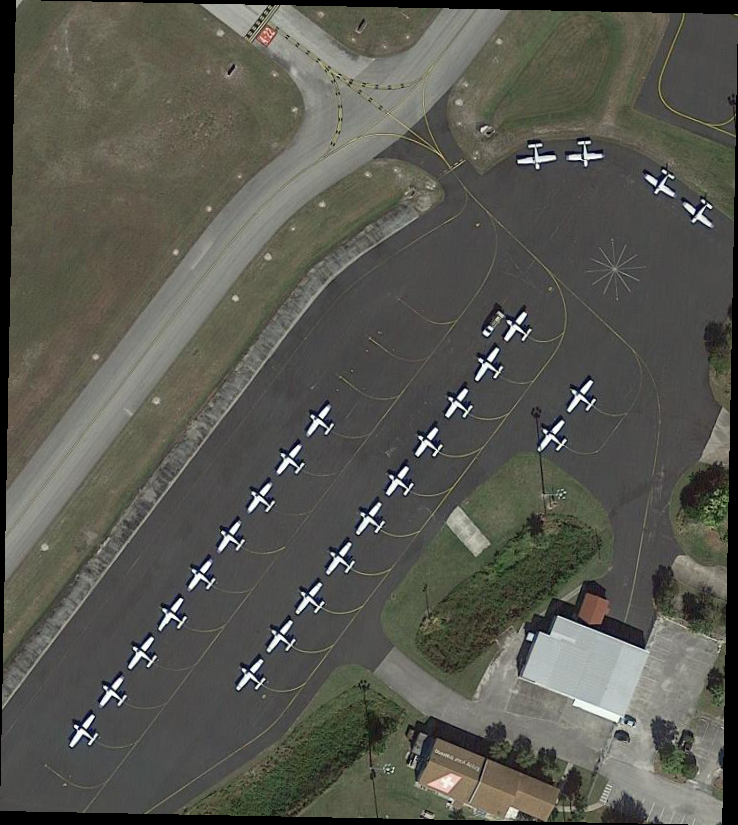

In [18]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

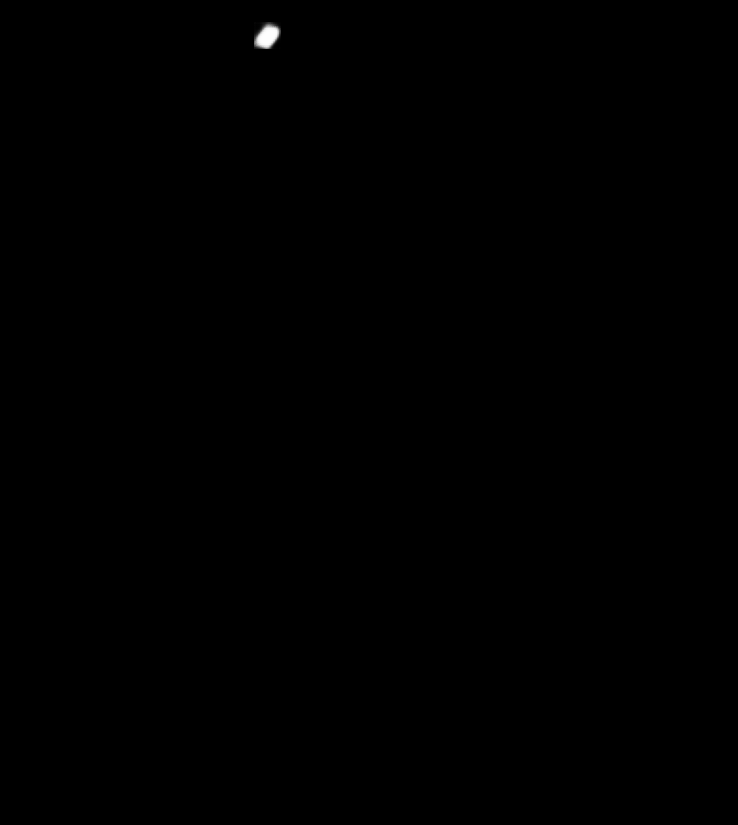

In [19]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [20]:
import numpy as np
# masks = prediction[0]['masks'].cpu().numpy()
masks = prediction[0]['masks'].cpu()

In [21]:
sum_result = torch.sum(masks, dim=0).numpy()

In [22]:
sum_result = sum_result[0]

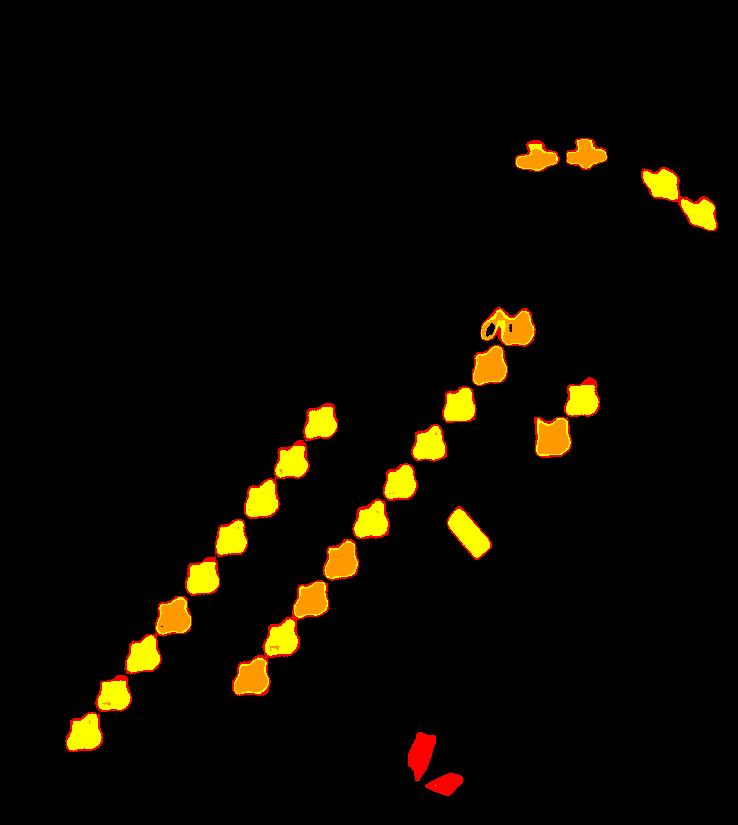

In [23]:
img = Image.fromarray(sum_result.astype(np.uint8))
img = img.convert("P")
# 定义调色板
palette = [
    0, 0, 0,  # 黑色背景
    255, 0, 0,  # 索引1为红色
    255, 255, 0,  # 索引2为黄色
    255, 153, 0,  # 索引3为橙色
]

# 应用调色板
img.putpalette(palette)
img

In [10]:
###非极大值抑制
import torch
import torchvision.ops as ops

def nms(labels, bboxs, scores, masks, iou_threshold):
    keep_indices = ops.nms(bboxs, scores, iou_threshold)
    
    # 保留的边界框、得分、标签和掩码
    keep_labels = labels[keep_indices]
    keep_bboxs = bboxs[keep_indices]
    keep_scores = scores[keep_indices]
    keep_masks = masks[keep_indices]

    return keep_labels, keep_bboxs, keep_scores, keep_masks

In [11]:
masks = prediction[0]['masks'].cpu()
bboxs = prediction[0]['boxes'].cpu()
scores = prediction[0]['scores'].cpu()
labels = prediction[0]['labels'].cpu()
iou_threshold = 0.2

In [12]:
keep_labels, keep_bboxs, keep_scores, keep_masks = nms(labels, bboxs, scores, masks, iou_threshold)

In [13]:
keep_masks.shape

torch.Size([51, 1, 870, 686])

In [14]:
sum_result = torch.sum(keep_masks, dim=0).numpy()

In [15]:
sum_result = sum_result[0]

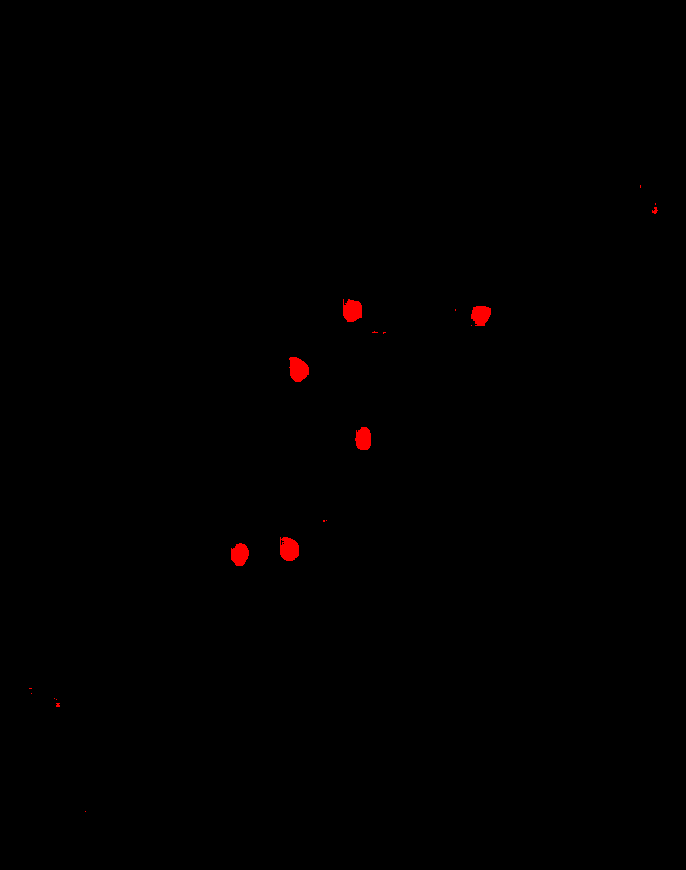

In [16]:
import numpy as np
img = Image.fromarray(sum_result.astype(np.uint8))
img = img.convert("P")
# 定义调色板
palette = [
    0, 0, 0,  # 黑色背景
    255, 0, 0,  # 索引1为红色
    255, 255, 0,  # 索引2为黄色
    255, 153, 0,  # 索引3为橙色
]

# 应用调色板
img.putpalette(palette)
img

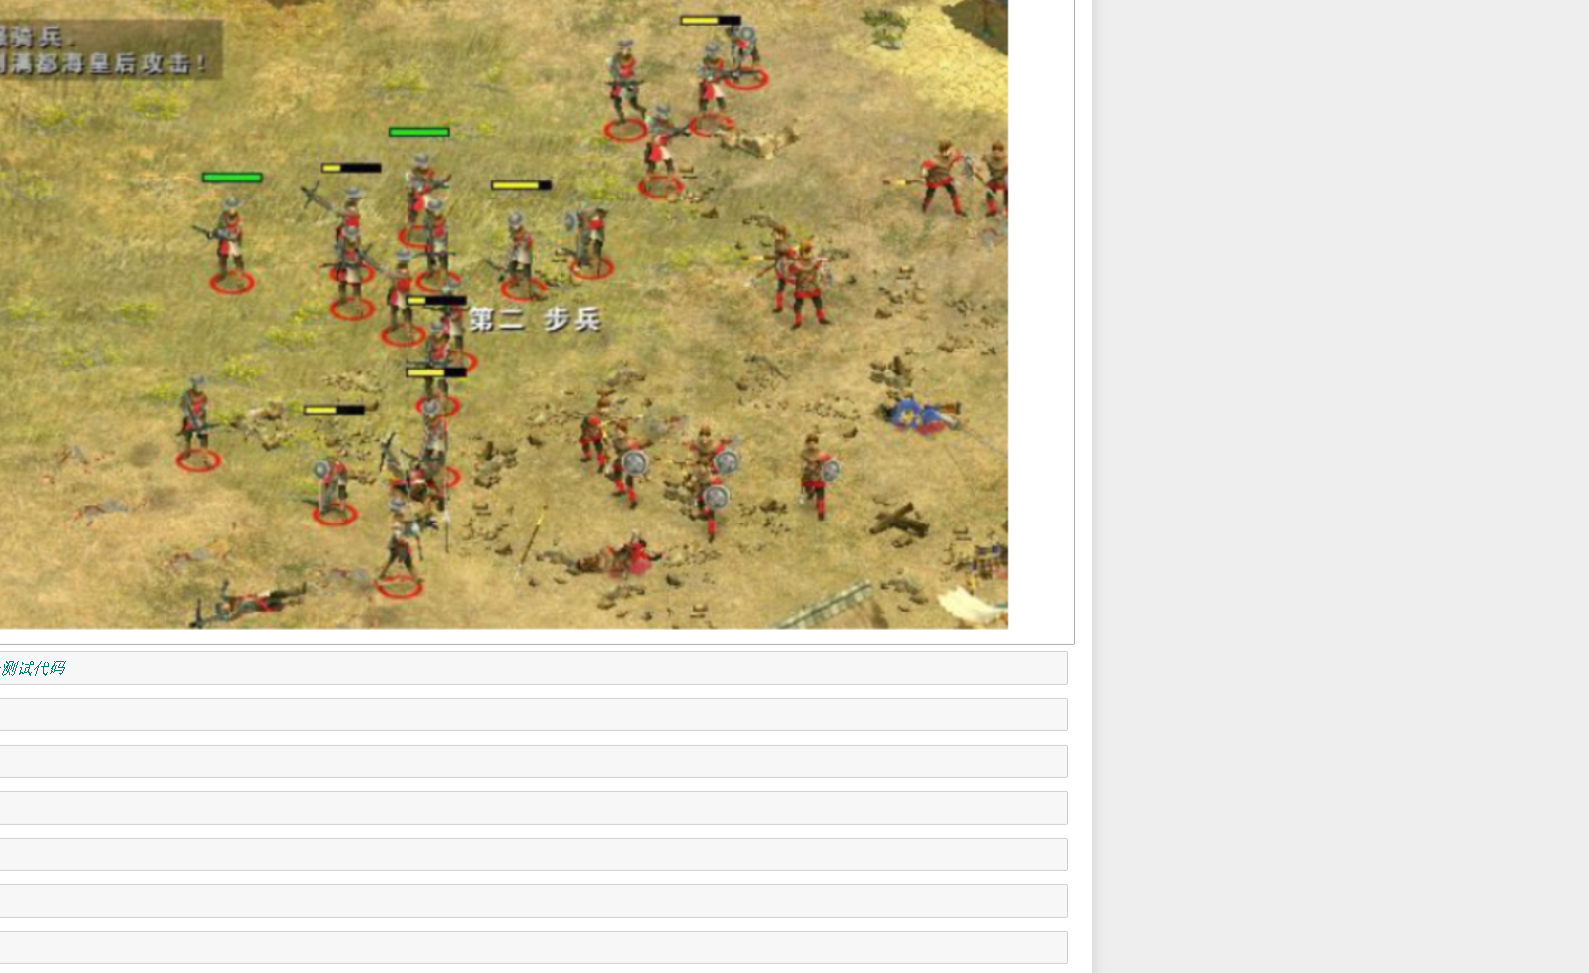

In [ ]:
#下面是测试代码

In [10]:
dataset = my_utils.landUseDataset('mydata/')
dataset_test = my_utils.landUseDataset('mydata/')
# torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-3])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-3:])

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [13]:
#img
dataset[0][0].shape

torch.Size([3, 363, 583])

In [14]:
dataset[0][1]

{'boxes': tensor([[117.0464, 113.4238, 389.5297, 398.7500],
         [273.2868,  58.9629, 885.9279, 234.0280]]),
 'labels': tensor([2, 2]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 'image_id': tensor([0]),
 'area': tensor([1096.6051, 2878.7129]),
 'iscrowd': tensor([0, 0])}

In [45]:
pic_name = 2
masks = dataset[pic_name-1][1]['masks']
sum_result = torch.sum(masks, dim=0).numpy()

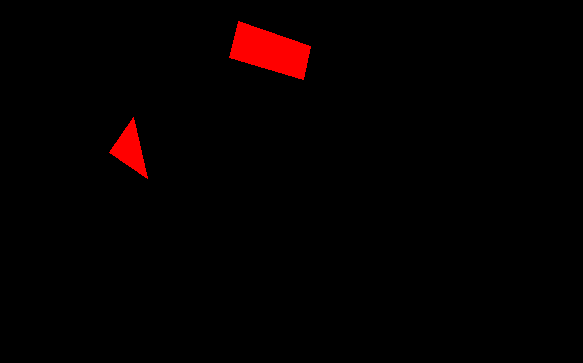

In [46]:
img = Image.fromarray(sum_result.astype(np.uint8))
img = img.convert("P")
# 定义调色板
palette = [
    0, 0, 0,  # 黑色背景
    255, 0, 0,  # 索引1为红色
    255, 255, 0,  # 索引2为黄色
    255, 153, 0,  # 索引3为橙色
]

# 应用调色板
img.putpalette(palette)
img